# Asia network example
network source and some code pieces from pgmpy demo

In [1]:
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import DiscreteFactor

## Get example model
list of possible options at the end of this file

In [2]:
from pgmpy.utils import get_example_model
model = get_example_model('asia')
model.get_cpds()

[<TabularCPD representing P(asia:2) at 0x2b78e436f70>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x2b78e436e20>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x2b78e436d30>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x2b78e436df0>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x2b78e436ee0>,
 <TabularCPD representing P(smoke:2) at 0x2b78e449340>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x2b78e449ac0>,
 <TabularCPD representing P(xray:2 | either:2) at 0x2b78e4498b0>]

In [3]:
model.nodes()

NodeView(('asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp'))

In [4]:
model.get_cardinality('smoke')

2

In [5]:
# Getting the local independencies of a variable.
model.local_independencies('dysp')

(dysp ⟂ asia, tub, smoke, xray, lung | either, bronc)

In [6]:
# Getting all the local independencies in the network.
model.local_independencies(['bronc', 'smoke', 'lung'])

(bronc ⟂ asia, tub, either, xray, lung | smoke)
(smoke ⟂ tub, asia)
(lung ⟂ bronc, tub, asia | smoke)

In [7]:
model.active_trail_nodes('smoke')

{'smoke': {'bronc', 'dysp', 'either', 'lung', 'smoke', 'xray'}}

In [8]:
model.active_trail_nodes('smoke', observed='xray')

{'smoke': {'asia', 'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'}}

In [9]:
model.get_parents('tub')

['asia']

## Conditional probability distribution

In [10]:
print(model.get_cpds('tub'))

+----------+-----------+----------+
| asia     | asia(yes) | asia(no) |
+----------+-----------+----------+
| tub(yes) | 0.05      | 0.01     |
+----------+-----------+----------+
| tub(no)  | 0.95      | 0.99     |
+----------+-----------+----------+


## Factor: more general probability potential

In [11]:
tub=model.get_cpds('tub')
print(tub.to_factor())

+----------+-----------+-----------------+
| tub      | asia      |   phi(tub,asia) |
+==========+===========+=================+
| tub(yes) | asia(yes) |          0.0500 |
+----------+-----------+-----------------+
| tub(yes) | asia(no)  |          0.0100 |
+----------+-----------+-----------------+
| tub(no)  | asia(yes) |          0.9500 |
+----------+-----------+-----------------+
| tub(no)  | asia(no)  |          0.9900 |
+----------+-----------+-----------------+


In [12]:
model.check_model()

True

## Daft graph display

node coordinates needed

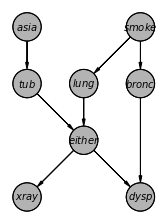

In [13]:
import matplotlib.pyplot as plt
import daft

plt.rcParams['figure.facecolor'] = 'white'
#
pos={'asia': (1, 4), 'smoke': (3, 4), 'tub': (1, 3), 'lung': (2, 3),
                         'bronc': (3, 3),'either': (2, 2),'xray': (1, 1),'dysp': (3, 1)}
model.to_daft(node_pos=pos).render()

In [14]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
g_dist = infer.query(['lung'],show_progress=False)
print(g_dist)

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.0550 |
+-----------+-------------+
| lung(no)  |      0.9450 |
+-----------+-------------+


Width: 5
['either', 'tub', 'bronc', 'lung', 'asia', 'smoke', 'xray', 'dysp']


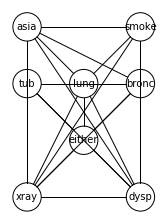

In [31]:
from pgmpy.inference.EliminationOrder import WeightedMinFill
import matplotlib.pyplot as plt
import daft
import sys

plt.rcParams['figure.facecolor'] = 'white'

## Transforms pgmpy.models.BayesianModel to daft.PGM
def to_daft(model,pos):
    daft_model=daft.PGM()
    for node in model.nodes:
        daft_model.add_node(daft.Node(node, node,pos[node][0],pos[node][1]))
    for edge in model.edges:
        try:
            daft_model.add_edge(edge[0],edge[1],directed=False)
        except:
            print(sys.exc_info())
    return daft_model

order=['either', 'tub','bronc','lung', 'asia', 'smoke', 'xray', 'dysp']
#order=WeightedMinFill(model).get_elimination_order(nodes=None, show_progress=False)
gg=infer.induced_graph(order)

print('Width: {}'.format(infer.induced_width(order)))
print(order)
mm=to_daft(gg,pos)
mm.render()



In [28]:
elim_o=WeightedMinFill(model)#.get_elimination_order(nodes=None, show_progress=False)
for node in order:
    fill=list(elim_o.fill_in_edges(node))
    if len(fill)>0:
            print('{}: fills {}'.format(node,fill))

either: fills [('xray', 'dysp')]
smoke: fills [('lung', 'bronc')]


In [15]:
print(infer.query(['lung'], evidence={'xray': 'yes'},show_progress=False))

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.4887 |
+-----------+-------------+
| lung(no)  |      0.5113 |
+-----------+-------------+


In [16]:
print(infer.query(['lung'], evidence={'xray': 'yes','smoke':'yes'},show_progress=False))

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.6460 |
+-----------+-------------+
| lung(no)  |      0.3540 |
+-----------+-------------+


In [17]:
print(infer.query(['lung'], evidence={'xray': 'yes','asia':'yes'},show_progress=False))

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.3715 |
+-----------+-------------+
| lung(no)  |      0.6285 |
+-----------+-------------+


## Read and write models in pgmpy


Unfortunatelly, the standard *.net format is not supported.

In [18]:
from pgmpy.readwrite import BIFReader, BIFWriter
writer = BIFWriter(model)
writer.write_bif(filename='{}.bif'.format('example'))

## Other sample models

The continuous ones did not work when I tried them.



pgmpy examples

Options:
            Small Networks:
                1. asia
                2. cancer
                3. earthquake
                4. sachs
                5. survey
            Medium Networks:
                1. alarm
                2. barley
                3. child
                4. insurance
                5. mildew
                6. water
            Large Networks:
                1. hailfinder
                2. hepar2
                3. win95pts
            Very Large Networks:
                1. andes
                2. diabetes
                3. link
                4. munin1
                5. munin2
                6. munin3
                7. munin4
                8. pathfinder
                9. pigs
                10. munin
        Gaussian Bayesian Network Options:
                1. ecoli70
                2. magic-niab
                3. magic-irri
                4. arth150
        Conditional Linear Gaussian Bayesian Network Options:
                1. sangiovese
                2. mehra

In [19]:
from pgmpy.utils import get_example_model
names=['earthquake','barley']
model2 = get_example_model(names[1])


In [20]:
import graphviz
dot = graphviz.Digraph(comment='')

for nd in model2.nodes():
    dot.node(nd,nd)

dot.edges(model2.edges)
dot.render('test-output/{}.gv'.format(names[1]), view=False) 

'test-output\\barley.gv.pdf'